In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
from sympy import lambdify
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Latex, Markdown, Image, Math
from scipy.integrate import solve_ivp
from scipy.signal import place_poles
import sympy as sp

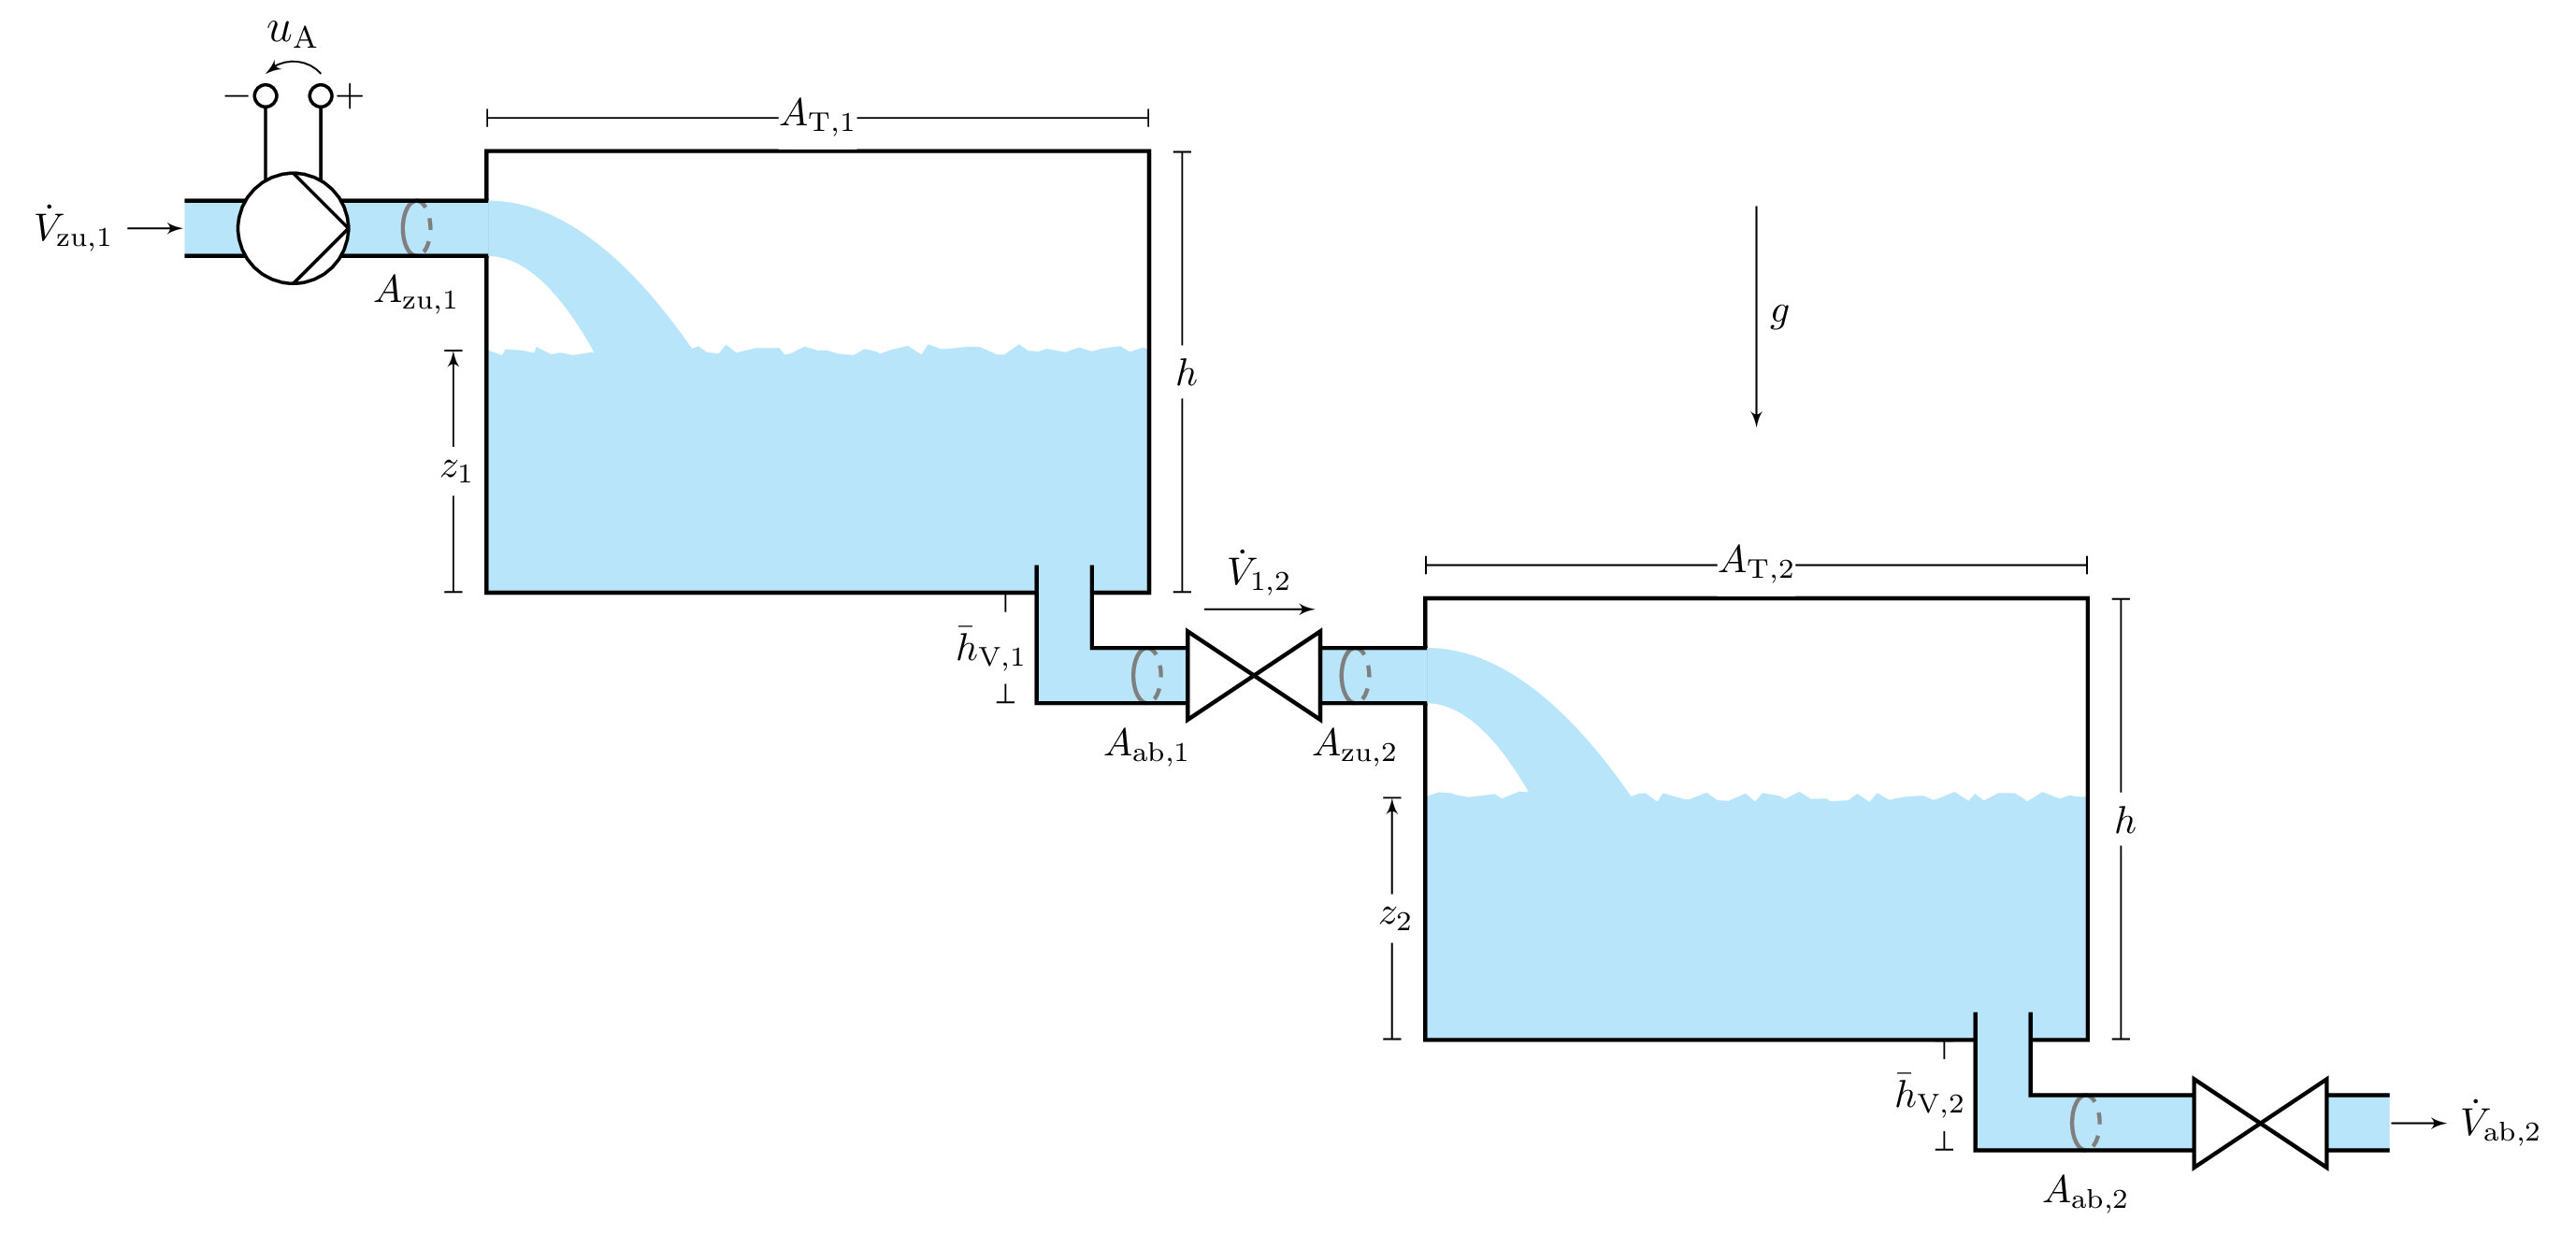

In [2]:
imag = Image("../../images/zweitank.png", width=800)
display(imag)

__System__

In [3]:
_t, s, yf, dyf, ddyf = sp.symbols('t s yf dyf ddyf')

In [4]:
z1 = sp.Function('z_1')
z2 = sp.Function('z_2')
uA = sp.Function('u_A')
y = sp.Function('y')
z = sp.Matrix([[z1(_t)], [z2(_t)]])

In [5]:
dz1 = 0.00216625315586689 * uA(_t) - 0.0127646468529449 * np.sqrt(2) * sp.sqrt(z1(_t))
dz2 = 0.0127646468529449 * np.sqrt(2) * sp.sqrt(z1(_t)) - 0.00908683019582126 * np.sqrt(2) * sp.sqrt(z2(_t))

dz = sp.Matrix([[dz1], [dz2]])
display(Latex("$\\dot{{\\mathbf{{z}}}} = {}$".format(sp.latex(dz))))

<IPython.core.display.Latex object>

__Flacher Ausgang__

In [6]:
display(Latex("$y(t) = z_2(t)$"))
dy = dz[1]
display(Latex("$\\dot{{y}}(t) = \\dot{{z}}_2(t) = {}$".format(sp.latex(dy))))
ddy = sp.simplify(dz[1].diff(_t).subs({z1(_t).diff(_t): dz1, z2(_t).diff(_t): dz2}))
display(Latex("$\\ddot{{y}}(t) = \\ddot{{z}}_2(t) = {}$".format(sp.latex(ddy))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
_z1 = sp.solve(dy.subs({z2(_t): y(_t)}) - y(_t).diff(_t), z1(_t))[0]
display(Latex("$z_1(t) = {}$".format(_z1)))
z1Sym = lambdify((yf, dyf), _z1.subs({y(_t): yf, y(_t).diff(_t): dyf}))

<IPython.core.display.Latex object>

In [8]:
display(Latex("$\\dot{{y}}(t) = \\dot{{z}}_2(t) = {}$".format(sp.latex(sp.simplify(dy.subs({
    z1(_t): _z1,
    z2(_t): y(_t)
}))))))
display(Latex("$\\ddot{{y}}(t) = \\ddot{{z}}_2(t) = {}$".format(sp.latex(sp.simplify(ddy.subs({
    z1(_t): _z1,
    z2(_t): y(_t)
}))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
_uA = sp.simplify(sp.solve(ddy.subs({z1(_t): _z1, z2(_t): y(_t)}) - y(_t).diff(_t, 2), uA(_t))[0])
display(Latex("$u_{{\\mathrm{{A}}}}(t) = {}$".format(sp.latex(_uA))))

<IPython.core.display.Latex object>

In [10]:
u = lambdify((yf, dyf, ddyf), _uA.subs({y(_t): yf, y(_t).diff(_t): dyf, y(_t).diff(_t,2): ddyf}))

__Definition Parammeter__

In [11]:
tSim = np.linspace(0, 500, 501)

In [12]:
x0 = [0.0, 0.0]
t0 = 0
yd = 0.2
dt = 250

In [13]:
yr = lambda t: yd * (10 * (t - t0) ** 3 / dt ** 3 - 15 * (t - t0) ** 4 / dt ** 4 + 6 * (t - t0) ** 5 / dt ** 5) if t0 <= t <= t0 + dt else 0 if t < t0 else yd 
dyr = lambda t: yd * (30 * (t - t0) ** 2 / dt ** 3 - 60 * (t - t0) ** 3 / dt ** 4 + 30 * (t - t0) ** 4 / dt ** 5) if t0 < t < t0 + dt else 0
ddyr = lambda t: yd * (60 * (t - t0) / dt ** 3 - 180 * (t - t0) ** 2 / dt ** 4 + 120 * (t - t0) ** 3 / dt ** 5) if t0 < t < t0 + dt else 0

## Steuerung

In [14]:
def prozessFF(_t, x, u):
    z1 = x[0]
    z2 = x[1]
    
    uA = u(_t)
    if np.isnan(uA):
        uA = 0.0
        
    if z1 <= 1e-6:
        z1 = 0

    if z2 <= 1e-6:
        z2 = 0
        
    dx = np.zeros(2)
    dx[0] = 0.00216625315586689 * uA - 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1)
    dx[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(z2)

    return dx

In [15]:
uAt = lambda t: u(yr(t), dyr(t), ddyr(t))

resFF = solve_ivp(prozessFF, [tSim[0], tSim[-1]], x0,
                t_eval=tSim, args=(uAt, ))

<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar divide
  return (sqrt(yf)*(2833173.58082874*ddyf + 227.690052479948)*sqrt((dyf + 0.0128507185019118*sqrt(yf))**2) + 18204.1580771418*(dyf + 0.0128507185019118*sqrt(yf))**2)/sqrt(yf)


In [16]:
uAt = lambda t: u(yr(tSim[-1]), dyr(tSim[-1]), ddyr(tSim[-1]))

res = solve_ivp(prozessFF, [tSim[0], tSim[-1]], x0,
                t_eval=tSim, args=(uAt, ))

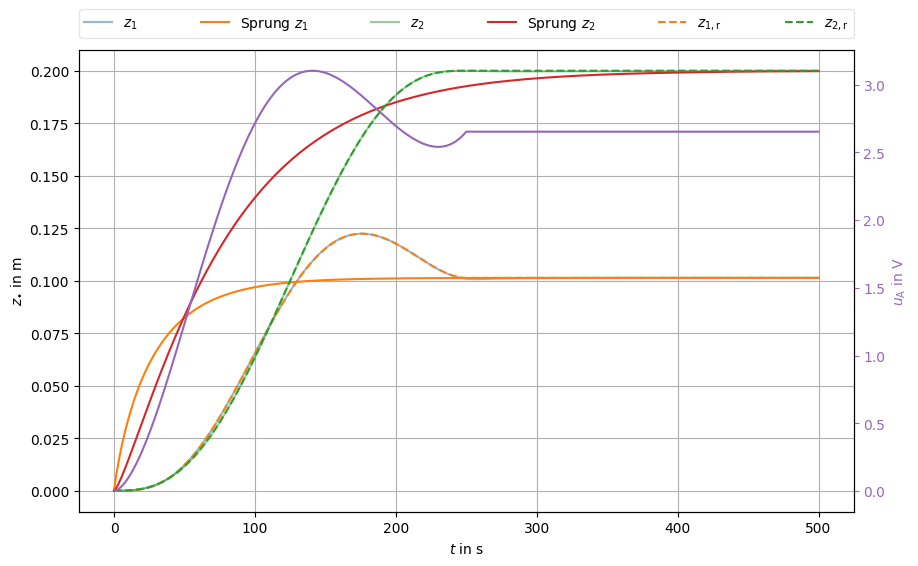

In [17]:
plt.close()

fig, axes10 = plt.subplots(1, 1, figsize=(10,6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

axes10.plot(resFF.t, resFF.y[0], 'C0', label=r"$z_1$", alpha=0.5)
axes10.plot(res.t, res.y[0], 'C1', label=r"Sprung $z_1$")
axes10.plot(resFF.t, resFF.y[1], 'C2', label=r"$z_2$", alpha=0.5)
axes10.plot(res.t, res.y[1], 'C3', label=r"Sprung $z_2$")
axes10.plot(tSim, [z1Sym(yr(t), dyr(t)) for t in tSim], 'C1--', label=r"$z_{1,\text{r}}$")
axes10.plot(tSim, [yr(t) for t in tSim], 'C2--', label=r"$z_{2,\text{r}}$")

axes11 = axes10.twinx()
axes11.plot(tSim, [u(yr(t), dyr(t), ddyr(t)) for t in tSim], 'C4')
axes11.set_ylabel(r"$u_{\mathrm{A}}$ in V", color='C4')
axes11.tick_params(axis='y', colors='C4')

axes10.set_xlabel(r"$t$ in s")
axes10.set_ylabel(r"$z_{\bullet}$ in m")

axes10.grid() 

handlesAx, labelsAx = axes10.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.125, 0.90, 0.775, .15), loc=3,
           ncol=6, mode="expand", borderaxespad=0., framealpha=0.5)
plt.show()

## Regelung

- Einführung Fehler
  \begin{align*}
      \ddot{e}(t) + K_1 \dot{e}(t) + K_0 e(t) & = 0, & e(t) & = y(t) - y_{\text{r}}(t), & K_0, K_1 & > 0
  \end{align*}
- Stellgesetz
  \begin{align*}
      \ddot{y}(t) & = \ddot{y}_{\text{r}}(t) - K_1 \dot{e}(t) - K_0 e(t)
  \end{align*}

In [18]:
def prozessCtrl(_t, x, u, yr, dyr, ddyr, K0, K1, inError):
    z1 = x[0]
    z2 = x[1]

    if z1 <= 1e-6:
        z1 = 0

    if z2 <= 1e-6:
        z2 = 0

    yrObs = z2
    dyrObs = 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(z2)

    e = yrObs - yr(_t)
    de = dyrObs - dyr(_t)
                                                                                                                                                       
    v = ddyr(_t) - K1 * de - K0 * e
    
    uA = u(yr(_t), dyr(_t), v) + inError

    if np.isnan(uA):
        uA = 0.0

    dx = np.zeros(2)
    dx[0] = 0.00216625315586689 * uA - 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1)
    dx[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(z2)

    return dx

In [19]:
x0 = [0.075, 0.05]
K1 = 4e-4
K0 = 7e-3
inError = 0.075

resCtrl = solve_ivp(prozessCtrl, [tSim[0], tSim[-1]], x0,
                    t_eval=tSim, args=(u, yr, dyr, ddyr, K0, K1, inError))

In [20]:
uCtrl = np.zeros(len(tSim))
for idx, t in enumerate(tSim):
    z1Ctrl = resCtrl.y[0, idx]
    z2Ctrl = resCtrl.y[1, idx]
    yrObs = z2Ctrl
    dyrObs = 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1Ctrl) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(z2Ctrl)

    e = yrObs - yr(t)
    de = dyrObs - dyr(t)
                                                                                                                                                       
    v = ddyr(t) - K1 * de - K0 * e
    uACtrl = u(yr(t), dyr(t), v) + inError
    if np.isnan(uACtrl):
        uACtrl = 0
    
    uCtrl[idx] = uACtrl

/tmp/ipykernel_260893/738840197.py:6: RuntimeWarning: invalid value encountered in sqrt
  dyrObs = 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1Ctrl) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(z2Ctrl)


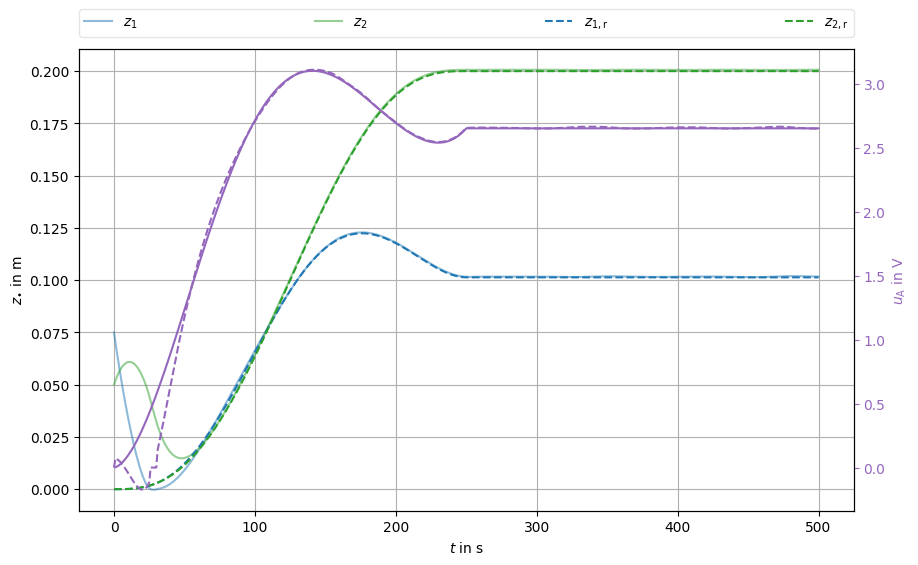

In [21]:
plt.close()

fig, axes10 = plt.subplots(1, 1, figsize=(10,6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

axes10.plot(resCtrl.t, resCtrl.y[0], 'C0', label=r"$z_1$", alpha=0.5)
axes10.plot(resCtrl.t, resCtrl.y[1], 'C2', label=r"$z_2$", alpha=0.5)
axes10.plot(tSim, [z1Sym(yr(t), dyr(t)) for t in tSim], 'C0--', label=r"$z_{1,\text{r}}$")
axes10.plot(tSim, [yr(t) for t in tSim], 'C2--', label=r"$z_{2,\text{r}}$")

axes11 = axes10.twinx()
axes11.plot(tSim, [u(yr(t), dyr(t), ddyr(t)) for t in tSim], 'C4')
axes11.plot(tSim, uCtrl, 'C4--')
axes11.set_ylabel(r"$u_{\mathrm{A}}$ in V", color='C4')
axes11.tick_params(axis='y', colors='C4')

axes10.set_xlabel(r"$t$ in s")
axes10.set_ylabel(r"$z_{\bullet}$ in m")

axes10.grid() 

handlesAx, labelsAx = axes10.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.125, 0.90, 0.775, .15), loc=3,
           ncol=6, mode="expand", borderaxespad=0., framealpha=0.5)
plt.show()

## Vergleich mit linearen Zustandsregler

- Ruhelage

In [22]:
barz2 = yr(tSim[-1])
barz1 = z1Sym(yr(tSim[-1]), dyr(tSim[-1]))
baruA = u(yr(tSim[-1]), dyr(tSim[-1]), ddyr(tSim[-1]))

- System- und Transformationsmatrix

In [23]:
A = np.array(dz.jacobian(sp.Matrix([[z1(_t)], [z2(_t)]])).subs({
    z1(_t): barz1,
    z2(_t): barz2
})).astype(np.float64)
b = np.array(dz.jacobian(sp.Matrix([uA(_t)]))).astype(np.float64)

In [24]:
S = np.hstack((b, A.dot(b)))
q = np.array([0, 1]) @ np.linalg.inv(S)
T = np.vstack((q, q @ A))
ctrlA = T @ A @ np.linalg.inv(T)
ctrlC = np.array([0, 1]) @ np.linalg.inv(T)

- Reglerverstärkung

In [25]:
poles = np.array([-0.05, -0.06])
pp = place_poles(A, b, poles)
k = pp.gain_matrix[0].reshape((1,2))

- Steuerung

In [26]:
yrSS = lambda t: -barz2 / ctrlC[0] + (barz2 / ctrlC[0]) * (10 * (t - t0) ** 3 / dt ** 3 - 15 * (t - t0) ** 4 / dt ** 4 + 6 * (t - t0) ** 5 / dt ** 5) if t0 <= t <= t0 + dt else -barz2 / ctrlC0 if t < t0 else 0
dyrSS = lambda t: (barz2 / ctrlC[0]) * (30 * (t - t0) ** 2 / dt ** 3 - 60 * (t - t0) ** 3 / dt ** 4 + 30 * (t - t0) ** 4 / dt ** 5) if t0 < t < t0 + dt else 0
ddyrSS = lambda t: (barz2 / ctrlC[0]) * (60 * (t - t0) / dt ** 3 - 180 * (t - t0) ** 2 / dt ** 4 + 120 * (t - t0) ** 3 / dt ** 5) if t0 < t < t0 + dt else 0

In [27]:
def prozessSSCtrl(t, x, yr, dyr, ddyr, k, ctrlA, T, barz1, barz2, baru, inError):
    z1 = x[0]
    z2 = x[1]

    if z1 <= 1e-6:
        z1 = 0

    if z2 <= 1e-6:
        z2 = 0

    uRef = ddyr(t) - ctrlA[-1, 1] * dyr(t) - ctrlA[-1, 0] * yr(t)
    zRef = np.linalg.inv(T).dot(np.array([yr(t), dyr(t)]))

    e = k @ (zRef - (np.array([z1, z2]) - np.array([barz1, barz2])))
    uA = (uRef + e + baru + inError)[0]

    dx = np.zeros(2)
    dx[0] = 0.00216625315586689 * uA - 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1)
    dx[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(z2)

    return dx

In [28]:
resSSCtrl = solve_ivp(prozessSSCtrl, [tSim[0], tSim[-1]], x0,
                      t_eval=tSim, args=(yrSS, dyrSS, ddyrSS, k, ctrlA, T, barz1, barz2, baruA, inError))

In [29]:
uCtrlSS = np.zeros(len(tSim))
for idx, t in enumerate(tSim):

    uRef = ddyrSS(t) - ctrlA[-1, 1] * dyrSS(t) - ctrlA[-1, 0] * yrSS(t)
    uCtrlSS[idx] = uRef + baruA

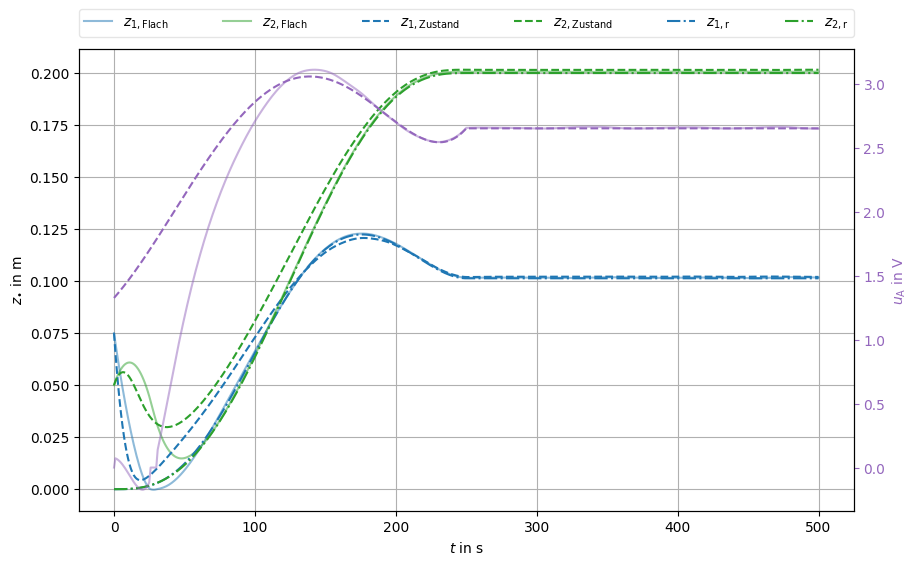

In [30]:
plt.close()

fig, axes10 = plt.subplots(1, 1, figsize=(10,6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

axes10.plot(resCtrl.t, resCtrl.y[0], 'C0', label=r"$z_{1,\text{Flach}}$", alpha=0.5)
axes10.plot(resCtrl.t, resCtrl.y[1], 'C2', label=r"$z_{2,\text{Flach}}$", alpha=0.5)
axes10.plot(resSSCtrl.t, resSSCtrl.y[0], 'C0--', label=r"$z_{1,\text{Zustand}}$")
axes10.plot(resSSCtrl.t, resSSCtrl.y[1], 'C2--', label=r"$z_{2,\text{Zustand}}$")
axes10.plot(tSim, [z1Sym(yr(t), dyr(t)) for t in tSim], 'C0-.', label=r"$z_{1,\text{r}}$")
axes10.plot(tSim, [yr(t) for t in tSim], 'C2-.', label=r"$z_{2,\text{r}}$")

axes11 = axes10.twinx()
axes11.plot(tSim, uCtrl, 'C4', alpha=0.5)
axes11.plot(tSim, uCtrlSS, 'C4--')
axes11.set_ylabel(r"$u_{\mathrm{A}}$ in V", color='C4')
axes11.tick_params(axis='y', colors='C4')

axes10.set_xlabel(r"$t$ in s")
axes10.set_ylabel(r"$z_{\bullet}$ in m")

axes10.grid() 

handlesAx, labelsAx = axes10.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.125, 0.90, 0.775, .15), loc=3,
           ncol=6, mode="expand", borderaxespad=0., framealpha=0.5)
plt.show()